# Методы сжатия и обработки видео

Полезные ссылки:
* [Telegram-чат](https://t.me/compression2020)
* [Документация pybind](https://pybind11.readthedocs.io/en/master/)

Понадобится для работы:
* Pybind11: `conda install -c conda-forge pybind11` (если у вас [Anaconda](www.anaconda.com) или `pip install pybind11`)
* Opencv2: `conda install -c conda-forge opencv` или `pip install opencv-python`) 
* C++ компилятор  

*Если у вас не заработало что-то, смело пишите в чатик курса*

## Задание 3. Motion Estimation ##

Шаблон для выполнения задания состоит из нескольких частей

1. Библиотека ME на C/C++, компилируемая для использования в python-коде. В основном писать код вам придётся именно в библиотеке. Чтобы скомпилировать библиотеку, запустите команду `python3 setup.py build_ext -i` в  корне папки с заданием. *Замечание. Это библиотека компилируется под C++, но внутри вам ничего не мешает писать код на чистом C.*
2. Ipython notebook для тестирования библиотеки. Используйте этот код для оценки качества работы программы и её улучшения.

### 1. Основная часть ###

Оценка качества работы алгоритма будет производиться следующим образом: на основе поля ME между двумя кадрами будет построен восстановленный кадр. Для оценивания качества будет использоваться PSNR между восстановленным и исходным кадром:

<img src="images/me_example.png">

<img src="images/how_it_works.png">

Кроме того, ещё одним параметром работы будет являться **скорость работы**.

In [1]:
# Импортируем нужные библиотеки
import cv2
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
%matplotlib inline

In [2]:
#Библиотека для чтения видео
class VideoReader:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
        print("Video height and width : {}x{}".format(self.height, self.width))
    
    def __iter__(self):
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            if ret == False:
                break
            yield frame
    
    def height(self):
        return self.heigth
    
    def width(self):
        return self.width
    
    def __del__(self):
        self.cap.release()

def generate_pair_frames_gray(video):
    prev_frame = None
    for frame in video:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if prev_frame is None:
            prev_frame = frame
        else:
            yield prev_frame, frame
            prev_frame = frame

In [3]:
def show_pair_frames(compensated_frame, frame, prev_frame, psnr_value):
    fig = plt.figure(figsize=(24 ,8))
    plt.suptitle('Значение PSNR: {:.4f}'.format(psnr_value), fontsize=24)
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(compensated_frame, cmap='gray')
    ax.set_title("Скомпенсированный кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(frame, cmap='gray')
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(prev_frame, cmap='gray')
    ax.set_title("Предыдущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Простая функция для тестирования ME.
def test_me(source_video, me, return_frames=False, result_path=None):
    ssim = []
    psnr = []
    speed = []
    previous_frames = []
    compensated_frames = []
    source_frames = []
    out_video = None
    if result_path is not None:
        out_video = cv2.VideoWriter(
            result_path,
            cv2.VideoWriter_fourcc(*'MP4V'),
            10,
            (source_video.width, source_video.height * 2)
        )
     
    pbar = tqdm(generate_pair_frames_gray(source_video))
    for prev_frame, frame in pbar:
        start = time.time()
        result = me.Estimate(prev_frame, frame)
        end = time.time()
        speed.append((end - start) * 1000)
        compensated_frame = me.Remap(prev_frame) # Скомпенсированный кадр лежит тут. Полезно для дебага его отсюда доставать и рассматривать.
        ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
        psnr.append(peak_signal_noise_ratio(frame, compensated_frame))
        if return_frames:
            compensated_frames.append(compensated_frame)
            previous_frames.append(prev_frame)
            source_frames.append(frame)
        
        
        pbar.set_description('PSNR: {:.2f}; Time(ms): {:.2f}; SSIM: {:.2f}.'.format(np.mean(psnr), np.mean(speed), np.mean(ssim)))
        
        if out_video is not None:
            out_video.write(cv2.cvtColor(np.vstack([frame, compensated_frame]), cv2.COLOR_GRAY2BGR))
    if out_video is not None:
        out_video.release()
        
    return {
        'ssim': ssim,
        'psnr': psnr,
        'speed': speed,
        'compensated_frames': compensated_frames,
        'previous_frames' : previous_frames,
        'source_frames': source_frames
    }

## Ваше решение

- В качестве решения вы должны прикрепить класс ниже.
- Менять прототипы для init и Estimate **нельзя**.
- **Должен** быть возможен вызов вида `test_me(video, me)`.

In [5]:
# GRADED CELL: MotionEstimator

class MotionEstimator:
    def __init__(self, width, height, quality, halfpixel):
        import me_estimator
        
        self.width = width
        self.height = height
        self.quality = quality
        self.halfpixel = halfpixel

        self.me = me_estimator.MotionEstimator(self.width, self.height, self.quality, self.halfpixel)
    def Estimate(self, frame, prev_frame):
        return self.me.Estimate(frame, prev_frame)
    
    def Remap(self, prev_frame):
        return self.me.Remap(prev_frame)
    
    def set_SearchMethod(self, method):
        """ 
        Input : method, pass
                0 for MODE::BruteForce
                1 for MODE::CrossSearch
                2 for MODE::OthonormalSearch
                3 for MODE::_3DRS
        """
        self.me.set_SearchMethod(self.get_cpp_input(method))
        
    def set_CrossSearch_ErrorThreshold(self, threshold):
        self.me.set_CrossSearch_ErrorThreshold(self.get_cpp_input(threshold))
        
    def set_CrossSearch_Side(self, side):
        self.me.set_CrossSearch_Side(self.get_cpp_input(side))
        
    def get_cpp_input(self, inp):
        return np.array([inp], dtype=np.int32)

**Если вы делали какие-то изменения, то не забудьте перезагрузить модуль. Для этого нажмите Kernel->Restart**

Чтобы проверить, как работет библиотека, давайте проверим его на одной последовательности на самом хорошем качестве.  
*То, что Ваше ME будет по качеству работать хуже полного перебора - это норма. Ваша задача - достаточно сильно ускорить ME, он должен работать ориентировочно за 5-10 мс на кадр. Ориентировочная точка - одно из самых лучших решений прошлого года на среднем ноутбуке показало **5.06ms и 35.1 psnr** на качестве 100.*

In [6]:
def test_method(method):
    video = VideoReader('video/source.avi')
    me = MotionEstimator(video.width, video.height, 100, False)
    me.set_SearchMethod(method)
    return test_me(video, me, True, 'result.mp4')
# Brute-force
result = test_method(0)

In [8]:
# Cross-search
result = test_method(1)

Video height and width : 288x352


In [16]:
# Orthonormal-search
result = test_method(2)

Video height and width : 288x352


Посмотрим на то, как компенсируется произвольный кадр:

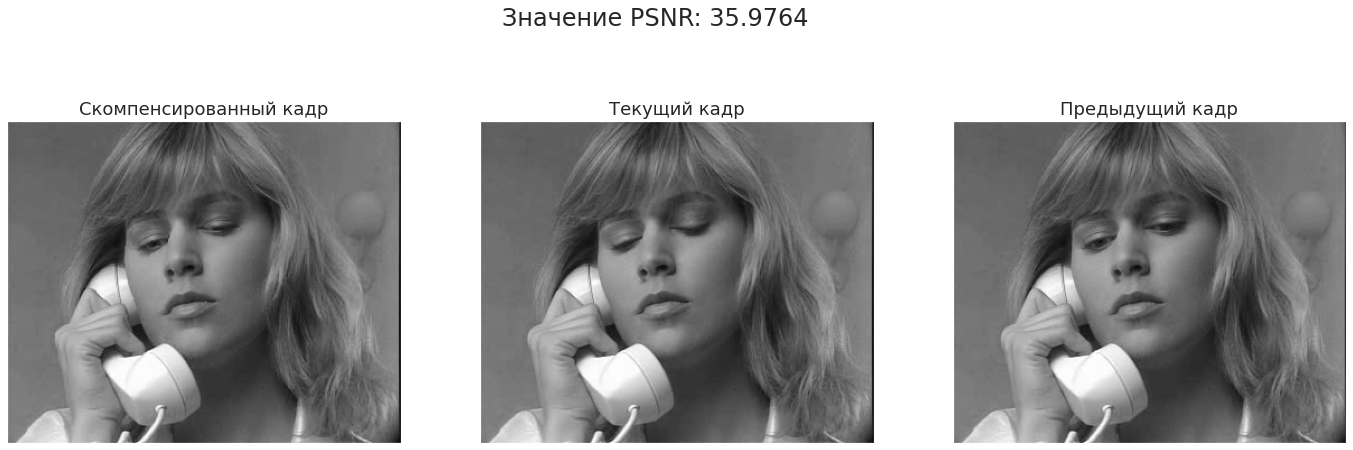

In [12]:
frame_idx = 3
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['previous_frames'][frame_idx],
    result['psnr'][frame_idx]
)

Примером ниже можно посмотреть графики, как покадрово работает ваш алгоритм. 

<Figure size 864x432 with 0 Axes>

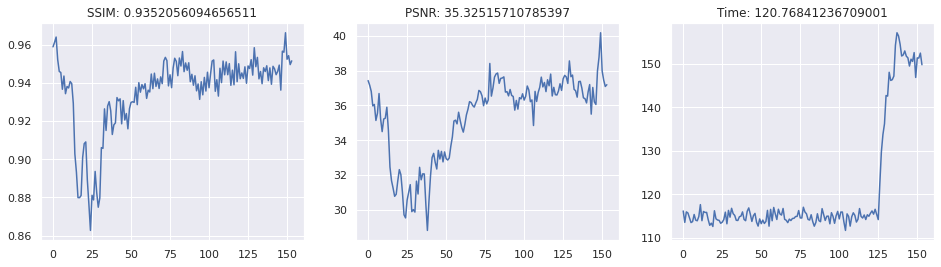

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

In [17]:
import pandas as pd

def test_all_me(video_paths=['source.avi'], qualities=[100, 80, 60, 40, 20], halfpixels=[False, True]):
    result = []
    for video_path in video_paths:
        for halfpixel in halfpixels:
            for quality in qualities:
                video = VideoReader(video_path)
                me = MotionEstimator(video.width, video.height, quality, halfpixel)
                metrics = test_me(video, me)
                result.append(
                    {
                        'video': video_path,
                        'halfpixel': halfpixel,
                        'quality': quality,
                        **{
                            key: np.mean(metrics[key])
                            for key in metrics
                        }
                    }
                )
    return pd.DataFrame(result)

In [18]:
result_all = test_all_me(
    video_paths=['video/source.avi'],
    qualities=[100],
    halfpixels=[False, True]
)

Video height and width : 288x352



Video height and width : 288x352


/home/eduard/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eduard/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Cross Search
result_all

,video,halfpixel,quality,ssim,psnr,speed,compensated_frames,previous_frames,source_frames
0,video/source.avi,False,100,0.417835,15.291511,79.187864,NaN,NaN,NaN
1,video/source.avi,True,100,0.417835,15.291511,94.446092,NaN,NaN,NaN


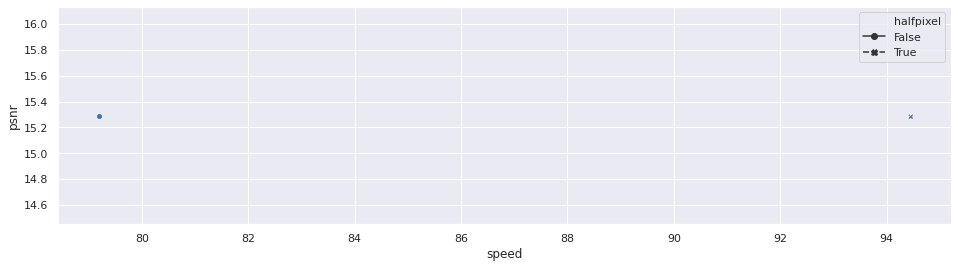

In [20]:
fig, axes = plt.subplots(1, len(result_all['video'].unique()), figsize=(16, 4))
if len(result_all['video'].unique()) == 1:
    axes = [axes]
for ax, video in zip(axes, result_all['video'].unique()):
    sns.lineplot(x='speed', y='psnr', style='halfpixel', markers=True, data=result_all[result_all.video == video], ax=ax)

## 2. Красивый вид кривых скорость/качество ##

*Это бонусное задание, за него вы получите баллы независимо от результатов в конкурсе*

Что хочется увидеть: у ME есть два ключевых параметра, определяющих его "хорошесть" - это скорость работы и качество сопоставления. Очевидно, можно написать метод, который делает полный перебор - он будет лучшим по качеству, но медленным, или наоборот - ничего не сопоставляем: ужасное качество, но замечательная скорость, Хочется, чтобы ваш алгоритм позволял варьировать скорость и качество и не уходил в такие крайности. Ниже пример кривых, которые были в прошлом году - хочется, чтобы форма кривых была как можно ближе к синей c треугольниками:

<img src="images/curves.png">

## 3. Опиши что было сделано ##

*Это тоже небольшое бонусное задание*  
Пожалуйста, опиши (кратко) суть твоего алгоритма, какие алгоритмы за основу ты взял и что решил улучшить.  
Также было бы неплохо, если ты приложишь графики, которые показывают, как каждое улучшение срабатывало.  
Если хочешь, можешь здесь вести небольшой дневник - какие эксперименты ты проводил, какие у тебя были гипотезы и какие у тебя получались результаты

### I. Multiple methods tested

* Brute-force
* Cross-search
* Orthonormal-search
* 3DRS coming

### II. Adding B-frames

According to [MPEG (moving pictures expert group) video compression algorithm: a review](https://sci-hub.do/10.1117/12.45402), MPEG uses B-frames in order to deal with uncovered areas from the future frames, hence we probably have to use them in order to significantly improve quality by increasing running time of our algorithm just by a factor of 2

### III. Checking frames, where we have the biggest error

We need as much PSNR as we can get, so we should be careful with ugly frames.

## 4. Немного подсказок

* Напишите сначала какой-нибудь базовый алгоритм, который будет вашим бейзлайном. Затем вы будете его постепенно улучшать
* После этого тестируйте каждое улучшение (одно улучшние - один эксперимент), чтобы не добавить в алгоритм то, что на самом деле ухушает алгоритм
* Не стесняйтесь проводить всякие эксперименты вне кода. Например, можно самостоятельно построить пример рельефа ошибки при сопоставлении, смотреть, насколько близки вектора у соседних блоков, исследовать стабильность векторов блоков по времени. Это позволит каждому улучшению работать максимально эффективно.